In [1]:
import os

os.environ['HADOOP_HOME'] = r'/home/ubuntu/spark-2.4.7-bin-hadoop2.7/hadoop-2.7.0/'
os.environ['HADOOP_COMMON_LIB_NATIVE_DIR'] = os.environ['HADOOP_HOME'] +'/lib/native'
os.environ['HADOOP_OPTS'] = "-Djava.library.path={}/lib".format(os.environ['HADOOP_HOME'])


In [2]:
from pyspark.sql.functions import from_unixtime, to_date, year, udf, explode, split, col, length, rank, dense_rank, avg, sum
from pyspark.sql import SparkSession
import sparknlp
import pandas as pd
pd.set_option('display.max_columns', 100, 'display.max_colwidth', 1000, 'display.max_rows', 1000,
              'display.float_format', lambda x: '%.2f' % x)

spark = SparkSession.builder \
    .master("local[*]")\
    .config("spark.driver.memory", "4G")\
    .config("spark.driver.maxResultSize", "2G") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.4.5")\
    .config("spark.kryoserializer.buffer.max", "1G")\
    .getOrCreate()

In [3]:
import tempfile
import os
import sparknlp
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import random
import string
import csv
import numpy as np
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel, SVMWithSGD, LogisticRegressionWithSGD
from pyspark.ml.feature import HashingTF, Tokenizer

%matplotlib inline
# If difficulty in import sc or SparkContext Manually
# Please uncomment the following to do so
#import pyspark
#sc = pyspark.SparkContext('local[*]')

plt.rcdefaults()


sparknlp.version()  # This is from JohnSnowLab

'2.6.3'

In [4]:
def load_json(file_location):
    file_type = "json"

    # CSV options
    infer_schema = "false"
    first_row_is_header = "false"
    delimiter = ","

    # The applied options are for CSV files. For other file types, these will be ignored.
    return spark.read.format(file_type) \
        .option("inferSchema", infer_schema) \
        .option("header", first_row_is_header) \
        .option("sep", delimiter) \
        .load(file_location)

Load training data

In [5]:
train_reviews = load_json("/home/ubuntu/notebooks/sample_amazon_review_5_train.json")

Load testing data

In [6]:
test_reviews = load_json("/home/ubuntu/notebooks/sampled_amazon_review_5_val.json")

In [7]:
train_reviews.cache()
test_reviews.cache()

DataFrame[asin: string, image: array<string>, overall: double, reviewText: string, reviewTime: string, reviewerID: string, reviewerName: string, style: struct<Capacity::string,Color Name::string,Color::string,Colorj::string,Configuration::string,Connectivity::string,Design::string,Diameter::string,Digital Storage Capacity::string,Display Height::string,Edition::string,Flavor Name::string,Flavor::string,Flex::string,Format::string,Gem Type::string,Gift Amount::string,Grip Type::string,Hand Orientation::string,Item Display Length::string,Item Display Weight::string,Item Package Quantity::string,Item Shape::string,Length::string,Loft::string,Material Type::string,Material::string,Metal Stamp::string,Metal Type::string,Model Number::string,Model::string,Number of Items::string,Offer Type::string,Outside Diameter::string,Overall Length::string,Package Quantity::string,Package Type::string,Part Number::string,Pattern::string,Platform for Display::string,Platform::string,Preamplifier Output C

In [8]:
# Create a view of train and test
train_reviews.createOrReplaceTempView("train_reviews")
test_reviews.createOrReplaceTempView("test_reviews")

In [9]:
spark.sql('select reviewText, overall from train_reviews').toPandas()

,reviewText,overall
0,"This is a great start, and a very cool example of the potential of Echo in a connected home. It's not perfect, though, and I don't get the sense that the Garageio manufacturer is incrementally enhancing this skill - I fear that's it's as good as its going to get.\n\nIssue #1\n\nEach garage door is given a name. I have one with my name and one with my wife's name. Our names are both single syllable, but start with different letters and have completely different phenomes.\n\nMe: Alexa, ask garageio to close Dean's door.\nEcho: Closing Mary's door.\nMe: What the heck?!?\n\nIt happens all the time, even when standing right next to the Echo. Sure, I could rename the doors to something that the Echo can distinguish between, but it shouldn't be necessary. I recognize that this is likely an Amazon thing and not a Garageio thing, but the fact that Echo sits in my house and can't distinguish between the spoken names of two residents in the home is kinda sad.\n\nIssue #2\n\nWe have thre...",2.00
1,I've played the game a handful of times and its rare it actually gets my animal right. It takes the same general concept of 21 questions but the pay off is never there.,1.00
2,I have been using automatic for more than a year and Alexa took it to another next level . This skill can even do more based our historic driving data and also using the driving score.,4.00
3,Exactly what I needed for my mother!,5.00
4,"It does not tell you when the reruns are on., only the next show you in the series. Not bad but not usefull if you want to watch sonething like love it or list it or sone other show that does mot need to be the newest show. It woukd also be nice to be able to set your cable company and fet actual channels, yo be hobest if I have to look up what network is on what channel I may as well look up the time too. Other then those things it does work as stated",3.00
...,...,...
359988,"Editing has been done and corrections made so the 5 stars are now well and truly worth it. Once again Halloween LaVue has gotten into more trouble than you can shake a stick at, or in this case a wedding dress at. This time though Halloweens mum and BFF are also affected. That doesn't go down well at all.",5.00
359989,Thank you,5.00
359990,Beautiful shirt!! It is super cute and fits so nicely. It hangs beautifully on me. Absolutely love it. It isn't to thick and it's not too thin either it is just right and the garments stitching is good. It is a high quality shirt. Absolutely love the material. It is super soft.,5.00
359991,"Top was too big, bottoms too small, cheaply made",1.00


Filter out null reviews

In [10]:
train_reviews = train_reviews.filter(train_reviews.reviewText.isNotNull())
test_reviews = test_reviews.filter(test_reviews.reviewText.isNotNull())

reviews.createOrReplaceTempView('reviews'): Creates a new temporary view using a SparkDataFrame in the Spark Session. If a temporary view with the same name already exists, replaces it.

In [11]:
train_reviews.createOrReplaceTempView('train_reviews')
test_reviews.createOrReplaceTempView('test_reviews')

In [12]:
spark.sql('SELECT COUNT(*) FROM train_reviews').toPandas()

,count(1)
0,359835


In [13]:
spark.sql('SELECT COUNT(*) FROM test_reviews').toPandas()

,count(1)
0,89964


## Clean Data

In [14]:
import re
from html import unescape

sw = stopwords.words("english")


def remove_stopwords(x):
    string = ''
    for x in x.split(' '):
        if x.lower() not in sw:
            string += x + ' '
        else:
            pass
    return string


def lower(text):
    return text.lower()


def removePunctuation(text):
    return re.sub('[^A-Za-z0-9 ]+', '', text)


@udf
def fixHTML(text):
    return unescape(text)


# UDF = user defined function
nosw = udf(remove_stopwords)
rp = udf(removePunctuation)
lc = udf(lower)
# Register UDF with Spark
spark.udf.register("nosw", nosw)
spark.udf.register("rp", rp)
spark.udf.register("lc", lc)

# Creates a new column in reviews which contains the review with no stop words
train_reviews = train_reviews.withColumn(
    'text_nosw', lc(rp(fixHTML(nosw('reviewText')))))
test_reviews = test_reviews.withColumn(
    'text_nosw', lc(rp(fixHTML(nosw('reviewText')))))

Label reviews

In [15]:
from pyspark.sql.functions import lit, when, col, regexp_extract

# label all reviews with greater than 3 stars as a positive review (1), else negative (0)
labelled_train = train_reviews.withColumn(
    'overall', when(col("overall") > 3, 1).otherwise(0))
labelled_test = test_reviews.withColumn(
    'overall', when(col("overall") > 3, 1).otherwise(0))
# Drop all columns except reviewText and sentiment label
labelled_train = labelled_train.select(
    [c for c in labelled_train.columns if c in {'text_nosw', 'overall'}])
labelled_test = labelled_test.select(
    [c for c in labelled_test.columns if c in {'text_nosw', 'overall'}])

# Rename text_nosw to text and overall to sentiment
labelled_train = labelled_train.withColumnRenamed(
    "text_nosw", "text").withColumnRenamed("overall", "sentiment")
labelled_test = labelled_test.withColumnRenamed(
    "text_nosw", "text").withColumnRenamed("overall", "sentiment")

labelled_train.toPandas()

,sentiment,text
0,0,great start cool example potential echo connected home perfect though get sense garageio manufacturer incrementally enhancing skill fear thats good going getissue 1each garage door given name one name one wifes name names single syllable start different letters completely different phenomesme alexa ask garageio close deans doorecho closing marys doorme heckit happens time even standing right next echo sure could rename doors something echo distinguish between necessary recognize likely amazon thing garageio thing fact echo sits house cant distinguish spoken names two residents home kinda sadissue 2we three garage doors 3 door garageio black box workalexa ask garageio doors openalexa ask garageio close doorswhats sadly necessaryalexa ask garageio deans door openalexa ask garageio marys door openalexa ask garageio close marys dooryou cant ask garageio doors open ask close doors ask status door turn much faster open garageio app scroll door status pages walk outside look gar...
1,0,ive played game handful times rare actually gets animal right takes general concept 21 questions pay never there
2,1,using automatic year alexa took another next level skill even based historic driving data also using driving score
3,1,exactly needed mother
4,0,tell reruns on next show series bad usefull want watch sonething like love list sone show mot need newest show woukd also nice able set cable company fet actual channels yo hobest look network channel may well look time too things work stated
...,...,...
359830,1,editing done corrections made 5 stars well truly worth it halloween lavue gotten trouble shake stick at case wedding dress at time though halloweens mum bff also affected go well all
359831,1,thank
359832,1,beautiful shirt super cute fits nicely hangs beautifully me absolutely love it thick thin either right garments stitching good high quality shirt absolutely love material super soft
359833,0,top big bottoms small cheaply made


In [16]:
# need equal number of negative and positive reviews
labelled_train.createOrReplaceTempView('labelled_train')
labelled_test.createOrReplaceTempView('labelled_test')

### Ensure there is not an imbalance in number of positive/negative reviews

Sample a random number of reviews from the larger class to match the smaller class

In [17]:
def balance_reviews(table_name):
    query = '''
    SELECT *
    FROM {}
    WHERE sentiment='{}'
    '''
    poscount = spark.sql(query.format(table_name, 1)).count()
    print("numPositive: " + str(poscount))

    negcount = spark.sql(query.format(table_name, 0)).count()
    print("numNegative: " + str(negcount))

    query = '''
        (SELECT *
        FROM {}
        WHERE sentiment='0'
        ORDER BY RAND() LIMIT {})
        UNION
        (SELECT *
        FROM {}
        WHERE sentiment='1'
        ORDER BY RAND() LIMIT {})
        '''.format(table_name, min(poscount, negcount), table_name, min(poscount, negcount))

    sampled_reviews = spark.sql(query)
    sampled_reviews.createOrReplaceTempView(table_name)
    return sampled_reviews

In [18]:
sampled_train_reviews = balance_reviews('labelled_train')
sampled_test_reviews = balance_reviews('labelled_test')

numPositive: 293317
numNegative: 66518
numPositive: 73453
numNegative: 16511


Compare number of positive and negative reviews after downsampling

In [19]:
query = '''
SELECT COUNT(*)
FROM labelled_train
WHERE sentiment='0'
'''
print(spark.sql(query).show())

query = '''
SELECT COUNT(*)
FROM labelled_train
WHERE sentiment='1'
'''
spark.sql(query).show()

+--------+
|count(1)|
+--------+
|   64391|
+--------+

None
+--------+
|count(1)|
+--------+
|   60662|
+--------+



In [20]:
query = '''
SELECT COUNT(*)
FROM labelled_test
WHERE sentiment='0'
'''
print(spark.sql(query).show())

query = '''
SELECT COUNT(*)
FROM labelled_test
WHERE sentiment='1'
'''
spark.sql(query).show()

+--------+
|count(1)|
+--------+
|   16111|
+--------+

None
+--------+
|count(1)|
+--------+
|   15272|
+--------+



In [21]:
sc = spark.sparkContext
##############################################
# Compute Ngram


def comp_ngram(df, ngram=2, input_col="split_text", output_col="ngram"):
    from pyspark.ml.feature import NGram

    ngram = NGram(n=ngram, inputCol=input_col, outputCol=output_col)
    return ngram.transform(df)


##############################################
# Compute TF

def CompTF(gram_df, input_col="ngram", output_col="tf", num_features=1 << 18):
    # now make term frequency vectors out of data frame to feed machine
    from pyspark.ml.feature import HashingTF
    hashingtf = HashingTF(inputCol=input_col, outputCol=output_col, numFeatures=num_features)
    return hashingtf.transform(gram_df)


##############################################
# Compute IDF

def CompIDF(tf, input_col="tf", output_col="idftf", minDocFreq=5):
    from pyspark.ml.feature import IDF
    tf.cache()

    idf = IDF(inputCol=input_col, outputCol=output_col, minDocFreq=5)
    idfModel = idf.fit(tf)
    return idfModel

##############################################
# Compute TFIDF


def CompTFIDF(tf, idf):
    tfidf = idf.transform(tf)
    return tfidf

##############################################
# Feature Extraction


def Convert_to_LabeledPoint(dataset):
    return dataset.rdd.map(lambda x: LabeledPoint(
        float(x.sentiment), MLLibVectors.fromML(x.idftf)))


#########################################
# Support Vector Machines

#Training - SVM


def SVM_train(training):
    return SVMWithSGD.train(training, iterations=20)

############################################
# Testing


def test(model, dataset):
    predictionAndLabel = dataset.map(
        lambda x: (x.label, model.predict(x.features)))

    return 1.0 * predictionAndLabel.filter(lambda x: x[0] == x[1]).count() / dataset.count()

##############################################
# Testing with pred prob


def test_wpp(model, labels, features):
    labels_and_probs = labels.zip(model.predict(features)).map(
        lambda x: {"actual": float(x[0]), "probs": float(x[1])})
    return labels_and_probs

#################################
# Final Test


def test_final(model, dataset):
    labels_and_preds = dataset.map(
        lambda x: {"actual": float(x.label), "predicted": float(model.predict(x.features))})
    acc = 100.0 * \
        ((labels_and_preds.filter(
            lambda x: x["actual"] == x["predicted"]).count()) / (dataset.count()))
    return (labels_and_preds, acc)

#############################
# tpr and fpr


def tf(labels_and_preds):
    true_pos = (labels_and_preds.filter(
        lambda x: x["predicted"] == 1 and x["actual"] == 1).count())
    true_neg = (labels_and_preds.filter(
        lambda x: x["predicted"] == 0 and x["actual"] == 0).count())
    false_pos = (labels_and_preds.filter(
        lambda x: x["predicted"] == 1 and x["actual"] == 0).count())
    false_neg = (labels_and_preds.filter(
        lambda x: x["predicted"] == 0 and x["actual"] == 1).count())

    tpr = (true_pos)/(true_pos+false_neg)
    fpr = (false_pos)/(false_pos+true_neg)
    return (tpr, fpr)

In [22]:
tokenizer = Tokenizer(inputCol="text", outputCol="split_text")
tokenized_train = tokenizer.transform(sampled_train_reviews)
tokenized_test = tokenizer.transform(sampled_test_reviews)

# Cache tokenized dataset as it will be re-used a lot
tokenized_train.cache()
tokenized_test.cache()

DataFrame[sentiment: int, text: string, split_text: array<string>]

In [23]:
tokenized_train.show()

+---------+--------------------+--------------------+
|sentiment|                text|          split_text|
+---------+--------------------+--------------------+
|        0|debating whether ...|[debating, whethe...|
|        0|bought january 20...|[bought, january,...|
|        0|small female tiny...|[small, female, t...|
|        0|came loose large ...|[came, loose, lar...|
|        0|readers lee child...|[readers, lee, ch...|
|        0|im nearly halfway...|[im, nearly, half...|
|        0|got 4 add item wo...|[got, 4, add, ite...|
|        0|        so so awful |     [so, so, awful]|
|        0|checkr nexus 6p s...|[checkr, nexus, 6...|
|        0|got item week ago...|[got, item, week,...|
|        0|doesnt even work ...|[doesnt, even, wo...|
|        0|bracket fit fence...|[bracket, fit, fe...|
|        0|boots arrived tim...|[boots, arrived, ...|
|        0|easy read book on...|[easy, read, book...|
|        0|worst street figh...|[worst, street, f...|
|        0|     get pay for 

# Naive Bayes Classification

In [24]:
def construct_tfidf_input(tokenized_train, tokenized_test, ngram=2, num_features=1 << 18):
    # now make n-gram input
    train_gram_df = comp_ngram(tokenized_train, ngram=ngram)
    test_gram_df = comp_ngram(tokenized_test, ngram=ngram)


    # now make term frequency vectors out of data frame to feed machine
    train_tf_df = CompTF(train_gram_df, num_features=num_features)
    test_tf_df = CompTF(test_gram_df, num_features=num_features)
    
    # tf-idf
    train_idfModel = CompIDF(train_tf_df)
    test_idfModel = CompIDF(test_tf_df)

    tfidf_train = CompTFIDF(train_tf_df, train_idfModel)
    # Use the train idf model as there are more samples, thus probably more representative
    tfidf_test = CompTFIDF(test_tf_df, train_idfModel)
    return tfidf_train, tfidf_test


In [25]:
# convert dataframe to rdd, to make a LabeledPoint tuple(label, feature, vector) for machine
from pyspark.mllib.linalg import Vectors as MLLibVectors
from pyspark.mllib.regression import LabeledPoint

# After experimentation, ngram = 1 and num_features=5000 gave best for NB
tfidf_train, tfidf_test = construct_tfidf_input(tokenized_train, tokenized_test, ngram=1, num_features=5000)

# we also need to convert ml.sparsevector mllib.sparse vector, because naive bayes only accepts mllib.sparsevector type
train_dataset = tfidf_train.rdd.map(lambda x: LabeledPoint(
    float(x.sentiment), MLLibVectors.fromML(x.idftf)))

test_dataset = tfidf_test.rdd.map(lambda x: LabeledPoint(
    float(x.sentiment), MLLibVectors.fromML(x.idftf)))

In [37]:
tfidf_train.show()

+---------+--------------------+--------------------+--------------------+--------------------+--------------------+
|sentiment|                text|          split_text|               ngram|                  tf|               idftf|
+---------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        0|small female tiny...|[small, female, t...|[small, female, t...|(5000,[43,49,55,8...|(5000,[43,49,55,8...|
|        0|quality would fin...|[quality, would, ...|[quality, would, ...|(5000,[23,288,322...|(5000,[23,288,322...|
|        0|photographer must...|[photographer, mu...|[photographer, mu...|(5000,[44,65,150,...|(5000,[44,65,150,...|
|        0|watching it quit ...|[watching, it, qu...|[watching, it, qu...|(5000,[357,718,22...|(5000,[357,718,22...|
|        0|first off book at...|[first, off, book...|[first, off, book...|(5000,[148,228,26...|(5000,[148,228,26...|
|        0|bad favorite tire...|[bad, favorite, t...|[bad, favor

In [38]:
# create Model
# now train and save the model
from pyspark.mllib.classification import NaiveBayes
import shutil

# training
print("************************TRAINING*******************************")
model_train_NB = NaiveBayes.train(train_dataset)
print("*****************************TRAINING COMPLETE************************************")

************************TRAINING*******************************
*****************************TRAINING COMPLETE************************************


In [39]:
# testing NB with training data

accuracy_NB_train = test(model_train_NB, train_dataset)

print("TRAINING ACCURACY:-\n")

print("The accuracy for the training dataset tested on the training data itself using NB is", accuracy_NB_train, "%")

print("\n")

TRAINING ACCURACY:-

The accuracy for the training dataset tested on the training data itself using NB is 0.7866264221035524 %




In [40]:
accu_NB = test(model_train_NB, test_dataset)

print("TESTING ACCURACY:-\n")

print("The accuracy for the testing dataset using NB is", accu_NB, "%")

print("\n")

TESTING ACCURACY:-

The accuracy for the testing dataset using NB is 0.771468584887644 %




### Find best ngram

ngram = 1 provides the best test accuracy

In [53]:
for i in range(1, 6):
    tfidf_train, tfidf_test = construct_tfidf_input(
        tokenized_train, tokenized_test, ngram=i)
    
    train_dataset = tfidf_train.rdd.map(lambda x: LabeledPoint(
        float(x.sentiment), MLLibVectors.fromML(x.idftf)))
    test_dataset = tfidf_test.rdd.map(lambda x: LabeledPoint(
        float(x.sentiment), MLLibVectors.fromML(x.idftf)))
    
    model_train_NB = NaiveBayes.train(train_dataset)
    accuracy = test(model_train_NB, test_dataset)
    print("NB accuracy with ngram {} is {}".format(i, accuracy))

NB accuracy with ngram 1 is 0.7048004987531172
NB accuracy with ngram 2 is 0.6203241895261845
NB accuracy with ngram 3 is 0.5185993349958438
NB accuracy with ngram 4 is 0.49781795511221943
NB accuracy with ngram 5 is 0.49438902743142144


### Word2Vec

Let's try comparing accuracy between using tfidf/ngram and Word2Vec

In [26]:
from pyspark.ml.feature import Word2Vec, MinMaxScaler


def constructWord2VecData(train_set, test_set, vector_size=100, minCount=5):
    # create an average word vector for each document
    word2vec = Word2Vec(vectorSize=vector_size, minCount=minCount,
                        inputCol='split_text', outputCol='word2vec')
    model = word2vec.fit(train_set)
    train_vec = model.transform(train_set)
    model = word2vec.fit(test_set)
    test_vec = model.transform(test_set)

    scaler = MinMaxScaler(inputCol="word2vec", outputCol="scaledFeatures")
    scaled_train = scaler.fit(train_vec).transform(train_vec)
    scaled_test = scaler.fit(test_vec).transform(test_vec)
    return scaled_train, scaled_test
scaled_train, scaled_test = constructWord2VecData(tokenized_train, tokenized_test)

In [27]:
scaled_train.show()

+---------+--------------------+--------------------+--------------------+--------------------+
|sentiment|                text|          split_text|            word2vec|      scaledFeatures|
+---------+--------------------+--------------------+--------------------+--------------------+
|        0|debating whether ...|[debating, whethe...|[0.03041657559179...|[0.51633070350080...|
|        0|bought january 20...|[bought, january,...|[-0.0699417433701...|[0.43708444194390...|
|        0|small female tiny...|[small, female, t...|[9.81444050315379...|[0.49308774609352...|
|        0|came loose large ...|[came, loose, lar...|[0.00876265610694...|[0.49923204954786...|
|        0|readers lee child...|[readers, lee, ch...|[-0.1077638457063...|[0.40721885386541...|
|        0|im nearly halfway...|[im, nearly, half...|[-0.1130789676235...|[0.40302185708415...|
|        0|got 4 add item wo...|[got, 4, add, ite...|[0.03808785167833...|[0.52238819786217...|
|        0|        so so awful |     [so

In [28]:
train_dataset_vec = scaled_train.rdd.map(lambda x: LabeledPoint(
    float(x.sentiment), MLLibVectors.fromML(x.scaledFeatures)))
test_dataset_vec = scaled_test.rdd.map(lambda x: LabeledPoint(
    float(x.sentiment), MLLibVectors.fromML(x.scaledFeatures)))

In [29]:
model_train_NB_vec = NaiveBayes.train(train_dataset_vec)
train_accuracy = test(model_train_NB_vec, train_dataset_vec)
print("NB accuracy on train dataset with word2vec is {}".format(train_accuracy))
accuracy = test(model_train_NB_vec, test_dataset_vec)
print("NB accuracy on test dataset with word2vec is {}".format(accuracy))

NB accuracy on train dataset with word2vec is 0.6020087482907247
NB accuracy on test dataset with word2vec is 0.5222891374310933


### Accuracy on Word2Vec is generally quite poor

## More detailed stats

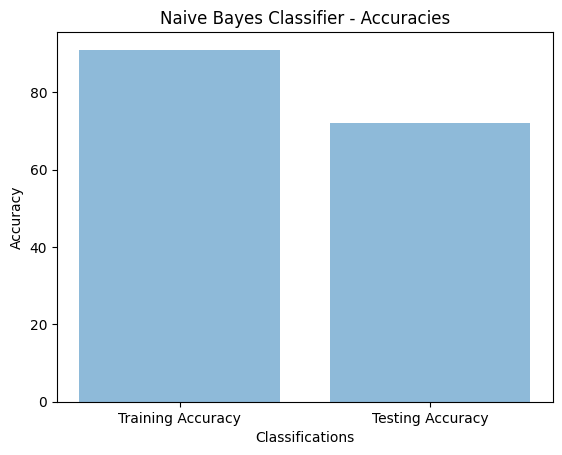

In [33]:
objects = ('Training Accuracy', 'Testing Accuracy')
y_pos = np.arange(len(objects))
performance = [accuracy_NB_train * 100, accu_NB]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Classifications')
plt.ylabel('Accuracy')
plt.title('Naive Bayes Classifier - Accuracies')

plt.show()

Here we calculate more advanced metrics to ensure our model is actually generalizing and not just predicting 1 or 0 every time

In [28]:
metrics = MulticlassMetrics(labels_and_preds_NB.map(
    lambda x: (x["predicted"], x["actual"])))
# Overall statistics
print("\nSummary Stats_NB\n")
# Statistics by class
labels = (sc.parallelize(
    [row[0] for row in sampled_test_reviews.collect()])).distinct().collect()
for label in sorted(labels):
    print("Class %s precision_NB = %s" % (label, metrics.precision(label)))
    print("Class %s recall_NB = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure_NB = %s" %
          (label, metrics.fMeasure(float(label), beta=1.0)))

# Weighted stats
print("\nAvg/Weighted recall_NB = %s" % metrics.weightedRecall)
print("Avg/Weighted precision_NB = %s" % metrics.weightedPrecision)
print("Avg/Weighted F(1) Score_NB = %s" % metrics.weightedFMeasure())

cm = metrics.confusionMatrix().toArray()
print("\nConfusion matrix_NB=")
print(cm)
print("\n")
metrics2 = BinaryClassificationMetrics(
    labels_and_preds_NB.map(lambda x: (x["predicted"], x["actual"])))

# Area under ROC curve
print("Area under ROC_NB = %s" % metrics2.areaUnderROC)


Summary Stats_NB

Class 0 precision_NB = 0.7188135390503528
Class 0 recall_NB = 0.7460741108559369
Class 0 F1 Measure_NB = 0.7321901745195382
Class 1 precision_NB = 0.7219654750577681
Class 1 recall_NB = 0.6931810766721044
Class 1 F1 Measure_NB = 0.7072805353041046

Avg/Weighted recall_NB = 0.7202888408194427
Avg/Weighted precision_NB = 0.7203501028407091
Avg/Weighted F(1) Score_NB = 0.7200467650216211

Confusion matrix_NB=
[[12020.  4091.]
 [ 4702. 10623.]]


Area under ROC_NB = 0.7196275937640206


# Logistic Regression

In [30]:
#######################################################
# Accuracy of Training data using train.csv itself using LG
# training
print("************************TRAINING*******************************")
model_train_LG = LogisticRegressionWithSGD.train(train_dataset, iterations=10, regType='l2')
print("*****************************TRAINING COMPLETE************************************")

************************TRAINING*******************************
*****************************TRAINING COMPLETE************************************


In [31]:
# testing NB with training data

accuracy_LG_train = test(model_train_LG, train_dataset)

print("TRAINING ACCURACY:-\n")

print("The accuracy for the training dataset tested on the training data itself using LG is", accuracy_LG_train, "%")

print("\n")

TRAINING ACCURACY:-

The accuracy for the training dataset tested on the training data itself using LG is 0.7887135854397735 %




In [32]:
labels_and_preds_LG, accu_LG = test_final(model_train_LG, test_dataset)

print("TESTING ACCURACY:-\n")

print("The accuracy for the testing dataset using LG is", accu_LG, "%")

print("\n")

TESTING ACCURACY:-

The accuracy for the testing dataset using LG is 78.27804862505178 %




### Try pyspark ml Logistic Regression instead of Pyspark mllib

In [33]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr_model = LogisticRegression(
    labelCol='sentiment', featuresCol='idftf', maxIter=100, regParam=0.7).fit(tfidf_train)

In [34]:
prediction_train = lr_model.transform(tfidf_train)
prediction_test = lr_model.transform(tfidf_test)

In [35]:
# evaluator = BinaryClassificationEvaluator(labelCol='sentiment')
# print(evaluator.evaluate(prediction_train))
# print(evaluator.evaluate(prediction_test))

In [36]:
train_accuracy = prediction_train.filter(
    prediction_train.sentiment == prediction_train.prediction).count() / float(tfidf_train.count())
print(train_accuracy)
test_accuracy = prediction_test.filter(
    prediction_test.sentiment == prediction_test.prediction).count() / float(tfidf_test.count())
test_accuracy

0.808201322639201


0.7953031896249562

### Test Word2Vec with Logistic Regression

In [37]:
model_train_LG_vec = LogisticRegressionWithSGD.train(train_dataset_vec, iterations=100, regType='l2')
train_accuracy = test(model_train_LG_vec, train_dataset_vec)
print("LG accuracy on train dataset with word2vec is {}".format(train_accuracy))
accuracy = test(model_train_LG_vec, test_dataset_vec)
print("LG accuracy on test dataset with word2vec is {}".format(accuracy))

LG accuracy on train dataset with word2vec is 0.6740581993234869
LG accuracy on test dataset with word2vec is 0.5576267405920403


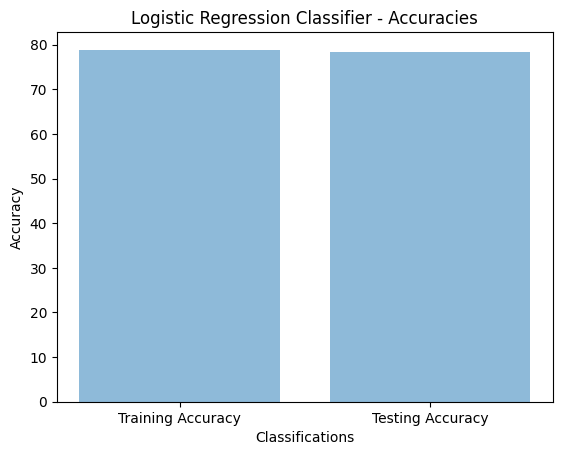

In [38]:
objects = ('Training Accuracy', 'Testing Accuracy')
y_pos = np.arange(len(objects))
performance = [accuracy_LG_train * 100.0, accu_LG]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Classifications')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Classifier - Accuracies')

plt.show()

In [39]:
metrics = MulticlassMetrics(labels_and_preds_LG.map(
    lambda x: (x["predicted"], x["actual"])))
# Overall statistics
print("\nSummary Stats_LG\n")
# Statistics by class
labels = (sc.parallelize(
    [row[0] for row in sampled_test_reviews.collect()])).distinct().collect()
for label in sorted(labels):
    print("Class %s precision_LG = %s" % (label, metrics.precision(label)))
    print("Class %s recall_LG = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure_LG = %s" %
          (label, metrics.fMeasure(float(label), beta=1.0)))

# Weighted stats
print("\nAvg/Weighted recall_LG = %s" % metrics.weightedRecall)
print("Avg/Weighted precision_LG = %s" % metrics.weightedPrecision)
print("Avg/Weighted F(1) Score_LG = %s" % metrics.weightedFMeasure())

cm = metrics.confusionMatrix().toArray()
print("\nConfusion matrix_LG=")
print(cm)
print("\n")
metrics2 = BinaryClassificationMetrics(
    labels_and_preds_LG.map(lambda x: (x["predicted"], x["actual"])))

# Area under ROC curve
print("Area under ROC_LG = %s" % metrics2.areaUnderROC)


Summary Stats_LG

Class 0 precision_LG = 0.8209697472026523
Class 0 recall_LG = 0.7377568121159457
Class 0 F1 Measure_LG = 0.7771421099087907
Class 1 precision_LG = 0.7500739426205265
Class 1 recall_LG = 0.8302776322682033
Class 1 F1 Measure_LG = 0.7881405973210679

Avg/Weighted recall_LG = 0.7827804862505178
Avg/Weighted precision_LG = 0.7864695169003157
Avg/Weighted F(1) Score_LG = 0.7824943356284573

Confusion matrix_LG=
[[11886.  4225.]
 [ 2592. 12680.]]


Area under ROC_LG = 0.7840172221920746


# Support Vector Machines

In [40]:
# Accuracy of Training data using train.csv itself using SVM

model_train_SVM = SVMWithSGD.train(train_dataset, iterations=20)
accuracy_SVM = test(model_train_SVM, train_dataset)
print("TRAINING ACCURACY:-\n")
print("The accuracy for the training dataset tested on the training data itself using SVM is", accuracy_SVM, "%")
print("\n")

TRAINING ACCURACY:-

The accuracy for the training dataset tested on the training data itself using SVM is 0.8010683470208632 %




In [41]:
labels_and_preds_SVM, accu_SVM = test_final(model_train_SVM, test_dataset)

print("TESTING ACCURACY:-\n")

print("The accuracy for the testing dataset using SVM is", accu_SVM, "%")

print("\n")

TESTING ACCURACY:-

The accuracy for the testing dataset using SVM is 79.36781059809451 %




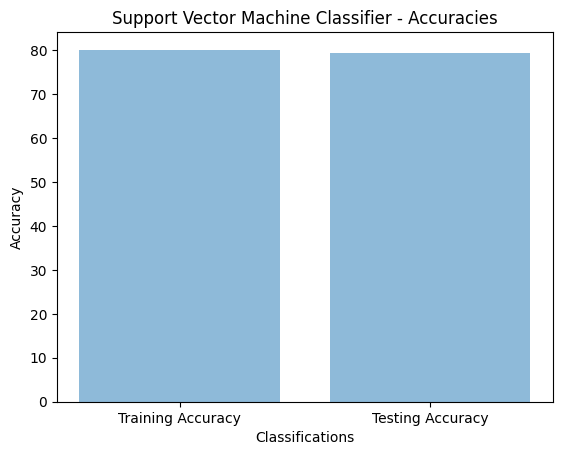

In [43]:
objects = ('Training Accuracy', 'Testing Accuracy')
y_pos = np.arange(len(objects))
performance = [accuracy_SVM * 100, accu_SVM]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Classifications')
plt.ylabel('Accuracy')
plt.title('Support Vector Machine Classifier - Accuracies')

plt.show()

In [44]:
metrics = MulticlassMetrics(labels_and_preds_SVM.map(
    lambda x: (x["predicted"], x["actual"])))
# Overall statistics
print("\nSummary Stats_SVM\n")
# Statistics by class
labels = (sc.parallelize(
    [row[0] for row in sampled_test_reviews.collect()])).distinct().collect()
for label in sorted(labels):
    print("Class %s precision_SVM = %s" % (label, metrics.precision(label)))
    print("Class %s recall_SVM = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure_SVM = %s" %
          (label, metrics.fMeasure(float(label), beta=1.0)))

# Weighted stats
print("\nAvg/Weighted recall_SVM = %s" % metrics.weightedRecall)
print("Avg/Weighted precision_SVM = %s" % metrics.weightedPrecision)
print("Avg/Weighted F(1) Score_SVM = %s" % metrics.weightedFMeasure())

cm = metrics.confusionMatrix().toArray()
print("\nConfusion matrix_SVM=")
print(cm)
print("\n")
metrics2 = BinaryClassificationMetrics(
    labels_and_preds_SVM.map(lambda x: (x["predicted"], x["actual"])))

# Area under ROC curve
print("Area under ROC_SVM = %s" % metrics2.areaUnderROC)


Summary Stats_SVM

Class 0 precision_SVM = 0.8133454734651405
Class 0 recall_SVM = 0.7762398361368009
Class 0 F1 Measure_SVM = 0.7943595769682725
Class 1 precision_SVM = 0.7747860311113888
Class 1 recall_SVM = 0.8120743844944998
Class 1 F1 Measure_SVM = 0.7929921033281115

Avg/Weighted recall_SVM = 0.793678105980945
Avg/Weighted precision_SVM = 0.7945811805796135
Avg/Weighted F(1) Score_SVM = 0.7936941193181901

Confusion matrix_SVM=
[[12506.  3605.]
 [ 2870. 12402.]]


Area under ROC_SVM = 0.7941571103156503


In [45]:
model_train_SVM_vec = SVMWithSGD.train(train_dataset_vec)
train_accuracy = test(model_train_SVM_vec, train_dataset_vec)
print("SVM accuracy on train dataset with word2vec is {}".format(train_accuracy))
accuracy = test(model_train_SVM_vec, test_dataset_vec)
print("SVM accuracy on test dataset with word2vec is {}".format(accuracy))

SVM accuracy on train dataset with word2vec is 0.5154214613004087
SVM accuracy on test dataset with word2vec is 0.5133671095816206


# Summary

All the models performed within 3% accuracy of each other on the test set, so there is no clear winner. However, Naive Bayes gives a good baseline, but there is not really any hyper parameters to tune so we can probably get higher accuracy using Logistic regression or SVM. The purpose of this model is to train using the labeled amazon reviews and once we are happy on it's accuracy with the Amazon reviews, we can use it in a domain where there are no labels, such as determining the sentiment regarding a certain topic on Twitter.

# Further tuning

I chose the SVM model to try to tune further to get the highest accuracy

In [77]:
# Try count vectorizer instead of Hashing TF
from pyspark.ml.feature import CountVectorizer

# now make n-gram input
train_gram_df = comp_ngram(tokenized_train, ngram=2)
test_gram_df = comp_ngram(tokenized_test, ngram=2)


# now make term frequency vectors out of data frame to feed machine
count_vectorizer = CountVectorizer(vocabSize=20000, inputCol="split_text", outputCol="tf")
train_cv_model = count_vectorizer.fit(tokenized_train)
train_cv = train_cv_model.transform(tokenized_train)
test_cv = train_cv_model.transform(tokenized_test)

# tf-idf
train_idfModel = CompIDF(train_cv)
test_idfModel = CompIDF(test_cv)

tfidf_train = CompTFIDF(train_cv, train_idfModel)
tfidf_test = CompTFIDF(test_cv, test_idfModel)

In [78]:
train_dataset_cv = tfidf_train.rdd.map(lambda x: LabeledPoint(
    float(x.sentiment), MLLibVectors.fromML(x.idftf)))
test_dataset_cv = tfidf_test.rdd.map(lambda x: LabeledPoint(
    float(x.sentiment), MLLibVectors.fromML(x.idftf)))

In [95]:
model_train_SVM = SVMWithSGD.train(train_dataset_cv, iterations=400, miniBatchFraction=0.5, regParam=0)
accuracy_SVM = test(model_train_SVM, train_dataset_cv)
print("TRAINING ACCURACY:-\n")
print("The accuracy for the training dataset tested on the training data itself using SVM is", accuracy_SVM, "%")
print("\n")

TRAINING ACCURACY:-

The accuracy for the training dataset tested on the training data itself using SVM is 0.8476805834326245 %




In [96]:
labels_and_preds_SVM, accu_SVM = test_final(model_train_SVM, test_dataset_cv)

print("TESTING ACCURACY:-\n")

print("The accuracy for the testing dataset using SVM is", accu_SVM, "%")

print("\n")

TESTING ACCURACY:-

The accuracy for the testing dataset using SVM is 82.16869005512538 %




The best accuracy I was able to get was 82%